In [ ]:
#importing libraries
from keras.models import Sequential
import tensorflow as tf
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import random
from numpy import *

from PIL import Image
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#stroring imagename, language, file path, language code
#here we use language code for tamil is 1, telugu is 0, urdu is 2
import pandas as pd
col=['filename','language','file_path','lan_code'] #creating dataframe
df=pd.DataFrame(columns=col)
p=os.listdir(r"C:\Users\91957\Desktop\final_project\process\train") #chaning directory lo location where we save spectrogram images
for i in p:
    l=i.split("_")
    f=i
    la=l[0]
    fp=r"C:\Users\91957\Desktop\final_project\process\train"+"/"+i
    if l[0]=="tamil":
        lc='0'
    elif l[0]=="telugu":
        lc='1'
    elif l[0]=="urdu":
        lc='2'

    df.loc[len(df.index)]=[i,la,fp,lc]



In [ ]:
#spliting dataframe into train and test
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

In [ ]:
test

,filename,language,gender,file_path,lan_code
0,tamil_1_1.wav.png,tamil,1,C:\Users\91957\Desktop\final_project\process\t...,0
2,tamil_1_11.wav.png,tamil,1,C:\Users\91957\Desktop\final_project\process\t...,0
6,tamil_1_15.wav.png,tamil,1,C:\Users\91957\Desktop\final_project\process\t...,0
7,tamil_1_16.wav.png,tamil,1,C:\Users\91957\Desktop\final_project\process\t...,0
17,tamil_1_25.wav.png,tamil,1,C:\Users\91957\Desktop\final_project\process\t...,0
...,...,...,...,...,...
723,urdu_6_30.wav.png,urdu,6,C:\Users\91957\Desktop\final_project\process\t...,2
727,urdu_6_34.wav.png,urdu,6,C:\Users\91957\Desktop\final_project\process\t...,2
734,urdu_6_40.wav.png,urdu,6,C:\Users\91957\Desktop\final_project\process\t...,2
743,urdu_6_49.wav.png,urdu,6,C:\Users\91957\Desktop\final_project\process\t...,2


In [ ]:
#image generatores
BATCH_SIZE = 8
EPOCHS = 5
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
#N_CLASSES = df['lan_code'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5


In [ ]:
#image generatores
BATCH_SIZE = 8
EPOCHS = 5
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = df['lan_code'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)

    train_generator=train_datagen.flow_from_dataframe(dataframe=train,

                                                      x_col="file_path",
                                                      y_col="lan_code",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')

    valid_generator=train_datagen.flow_from_dataframe(dataframe=train,

                                                      x_col="file_path",
                                                      y_col="lan_code",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=test,

                                                      x_col="file_path",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)

    return train_generator,valid_generator,test_generator


In [ ]:
train_generator,valid_generator,test_generator = img_generator(train,test)#calling image_generator function

Found 480 validated image filenames belonging to 3 classes.
Found 120 validated image filenames belonging to 3 classes.
Found 150 validated image filenames.


In [ ]:
#CNN model
import tensorflow as tf
import keras
cnn4 = Sequential()
cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3)))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Flatten())

cnn4.add(BatchNormalization())
cnn4.add(Dense(256, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.5))


cnn4.add(Dense(3, activation='softmax'))

cnn4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

cnn4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 286, 430, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 286, 430, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 284, 428, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 284, 428, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 142, 214, 64)     0         
 )                                                               
                                                      

In [ ]:
 earlystop = tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=0,
                patience=20,
                verbose=1,
                mode='auto')

In [ ]:
modelCheckPoint = tf.keras.callbacks.ModelCheckpoint(
                    filepath="./checkPointModel.h5",
                    save_best_only=True,
                    monitor='val_loss',
                    mode='auto',
                    verbose=1)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard
NAME = "recurrent_model"
tensorboard = TensorBoard(log_dir='./logs/recurrent_model')

In [ ]:
#CNN model training
cnn4.fit(train_generator, batch_size = BATCH_SIZE, epochs = 40, verbose = 1, validation_data = valid_generator,callbacks = [tensorboard , earlystop ,modelCheckPoint])

Epoch 1/40
60/60 [==============================] - ETA: 0s - loss: 1.5365 - accuracy: 0.5938
Epoch 00001: val_loss improved from inf to 7.84508, saving model to .\checkPointModel.h5
60/60 [==============================] - 503s 8s/step - loss: 1.5365 - accuracy: 0.5938 - val_loss: 7.8451 - val_accuracy: 0.3167
Epoch 2/40
60/60 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.7583
Epoch 00002: val_loss improved from 7.84508 to 2.70114, saving model to .\checkPointModel.h5
60/60 [==============================] - 536s 9s/step - loss: 0.7307 - accuracy: 0.7583 - val_loss: 2.7011 - val_accuracy: 0.3167
Epoch 3/40
60/60 [==============================] - ETA: 0s - loss: 0.5884 - accuracy: 0.7937
Epoch 00003: val_loss did not improve from 2.70114
60/60 [==============================] - 362s 6s/step - loss: 0.5884 - accuracy: 0.7937 - val_loss: 3.7173 - val_accuracy: 0.3167
Epoch 4/40
60/60 [==============================] - ETA: 0s - loss: 0.4027 - accuracy: 0.8458
E

In [ ]:
#predicting test data using CNN
train_preds =cnn4.predict_generator(test_generator, verbose = 1)

150/150 [==============================] - 31s 203ms/step


CNN Accuracy score : 0.653


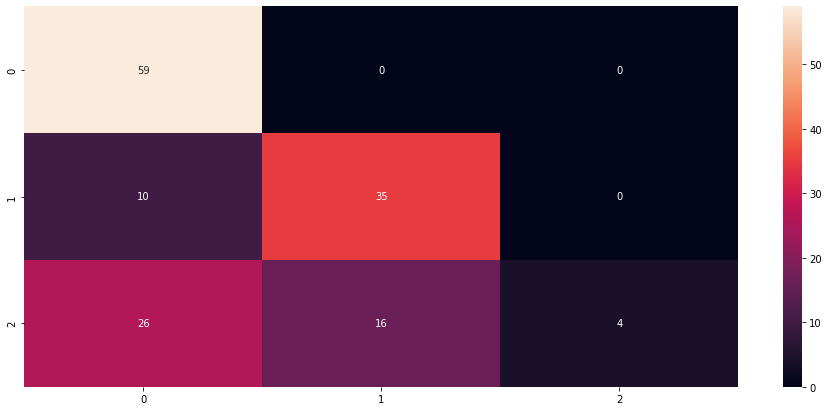

In [ ]:
#printing accuracy and confusion matrix of CNN
y_pred=np.argmax(train_preds,axis=1)
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
p=confusion_matrix(test['lan_code'].astype("int"),y_pred)
import seaborn as sns
plt.figure(figsize=(16, 7))
sns.heatmap(p,annot=True)
y_pred=np.argmax(train_preds,axis=1)
print("CNN Accuracy score : %.3f" % accuracy_score(test['lan_code'].astype('int'),y_pred))

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation,Flatten
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
import pandas as pd
from keras.applications.resnet import ResNet50
from keras.layers import BatchNormalization
from keras.layers import concatenate
from keras.layers import GlobalMaxPooling2D
import tensorflow as kf

In [ ]:
#ResNet50
import tensorflow as tf
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=3,
                   weights='imagenet')

#pretrained_model.summary()
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(3, activation='softmax'))
resnet_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])
#resnet_model.summary()

In [ ]:
#training ResNet50 model
resnet_model.fit(train_generator, batch_size = BATCH_SIZE, epochs = 40, verbose = 1, validation_data = valid_generator)

Epoch 1/40
60/60 [==============================] - 245s 4s/step - loss: 9.8976 - accuracy: 0.5042 - val_loss: 1784.1447 - val_accuracy: 0.3167
Epoch 2/40
60/60 [==============================] - 235s 4s/step - loss: 3.1910 - accuracy: 0.6500 - val_loss: 14.5807 - val_accuracy: 0.3000
Epoch 3/40
60/60 [==============================] - 233s 4s/step - loss: 1.8884 - accuracy: 0.6667 - val_loss: 1.0987 - val_accuracy: 0.3833
Epoch 4/40
60/60 [==============================] - 233s 4s/step - loss: 0.9861 - accuracy: 0.7542 - val_loss: 1.0960 - val_accuracy: 0.3833
Epoch 5/40
60/60 [==============================] - 237s 4s/step - loss: 0.3994 - accuracy: 0.8687 - val_loss: 1.0957 - val_accuracy: 0.3833
Epoch 6/40
60/60 [==============================] - 235s 4s/step - loss: 0.2918 - accuracy: 0.8958 - val_loss: 1.0964 - val_accuracy: 0.3833
Epoch 7/40
60/60 [==============================] - 246s 4s/step - loss: 0.4446 - accuracy: 0.8896 - val_loss: 1.1052 - val_accuracy: 0.3833
Epoch 8/4

150/150 [==============================] - 26s 172ms/step
ResNet50 Accuracy score : 0.967


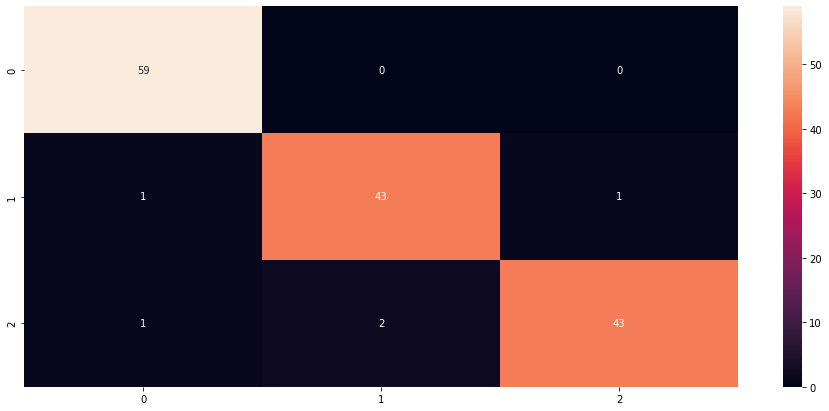

In [ ]:
train_preds1 =resnet_model.predict_generator(test_generator, verbose = 1)#predicting test data using ResNet50
y_pred1=np.argmax(train_preds1,axis=1)
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
p=confusion_matrix(test['lan_code'].astype("int"),y_pred1)
import seaborn as sns
plt.figure(figsize=(16, 7))
sns.heatmap(p,annot=True)#ploting confusion matrix
print("ResNet50 Accuracy score : %.3f" % accuracy_score(test['lan_code'].astype('int'),y_pred1))#finding accuracy

In [ ]:
#inceptionV3
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf
base_model = InceptionV3(weights='imagenet',
                                include_top=False,
                                input_shape=(224, 224,3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(Flatten())
add_model.add(Dense(1024,
                    activation='relu'))
add_model.add(Dropout(0.2))
add_model.add(Dense(3,
                    activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
#training InceptionV3
model.fit(train_generator, batch_size = BATCH_SIZE, epochs = 40, verbose = 1, validation_data = valid_generator,callbacks = [tensorboard , earlystop ,modelCheckPoint])

Epoch 1/40
60/60 [==============================] - ETA: 0s - loss: 46.0924 - accuracy: 0.4479
Epoch 00001: val_loss did not improve from 0.06356
60/60 [==============================] - 68s 1s/step - loss: 46.0924 - accuracy: 0.4479 - val_loss: 22.1650 - val_accuracy: 0.6083
Epoch 2/40
60/60 [==============================] - ETA: 0s - loss: 11.6893 - accuracy: 0.6208
Epoch 00002: val_loss did not improve from 0.06356
60/60 [==============================] - 63s 1s/step - loss: 11.6893 - accuracy: 0.6208 - val_loss: 6.3693 - val_accuracy: 0.6833
Epoch 3/40
60/60 [==============================] - ETA: 0s - loss: 3.5085 - accuracy: 0.7500
Epoch 00003: val_loss did not improve from 0.06356
60/60 [==============================] - 63s 1s/step - loss: 3.5085 - accuracy: 0.7500 - val_loss: 3.2350 - val_accuracy: 0.6333
Epoch 4/40
60/60 [==============================] - ETA: 0s - loss: 1.5376 - accuracy: 0.8083
Epoch 00004: val_loss did not improve from 0.06356
60/60 [=====================

150/150 [==============================] - 21s 141ms/step
InceptionV3 Accuracy score : 0.847


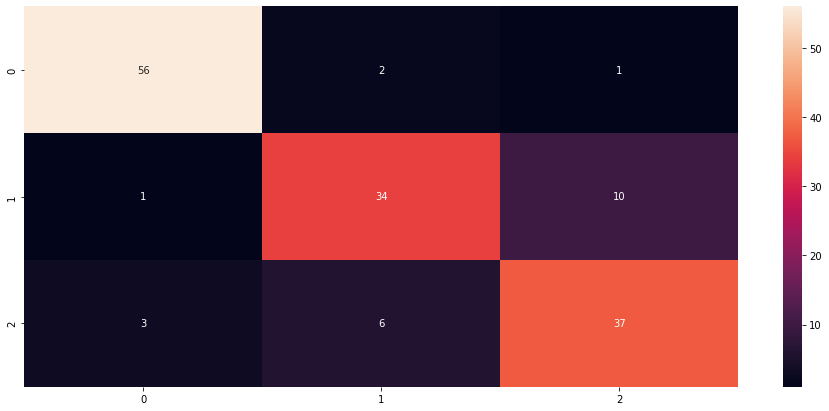

In [ ]:
train_preds2 =model.predict_generator(test_generator, verbose = 1)#predicting test data using InceptionV3
y_pred2=np.argmax(train_preds2,axis=1)
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
p=confusion_matrix(test['lan_code'].astype("int"),y_pred2)
import seaborn as sns
plt.figure(figsize=(16, 7))
sns.heatmap(p,annot=True)#ploting confusion matrix
print("InceptionV3 Accuracy score : %.3f" % accuracy_score(test['lan_code'].astype('int'),y_pred2))#accuracy